In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier as RFC
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt

# Can I predict what decade a book was written in, based on spelling?

Over 513,000 different unique spellings, not including stopwords, were used between 1550 and 1700.

### Shortcomings
Some decades have a lot more books than other decades.

data was a bit difficult to scrape. The scraper works, but the computer I was running it on wouldn't run the script for longer than about 15 minutes before it decided it was a good idea to log out and kill user processes. In the future I'll try to get around that, and we'll see that it affected the accuracy quite a bit.

### Methodologies
To get around the high number of words, I focused on some spelling changes I'd noticed when reading the data.  Sometimes, adverbs would end with "ly," as in the modern spelling, but sometimes they would end in "lie," which I believe happened when the printer ran out of "Y" tiles.  Similarly, there are some words where "vv" was used instead of "w", so I restricted my count vectors to those words.

In [2]:
X = []
y = []
for ii in tqdm(glob("*/*.nsv")):
    X.append(np.loadtxt(ii))
    y.append(ii[:4])

100%|█████████████████████████████████████████| 1672/1672 [00:20<00:00, 80.16it/s]


In [3]:
trainx,testx,trainy,testy = train_test_split(X,y,random_state=42)

In [4]:
forest = RFC()
Gauss = GaussianNB()

In [5]:
forest.fit(trainx,trainy)

RandomForestClassifier()

In [6]:
Gauss.fit(trainx,trainy)

GaussianNB()

In [7]:
forest_preds = forest.predict(testx)

In [8]:
gauss_preds = Gauss.predict(testx)

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
%matplotlib inline

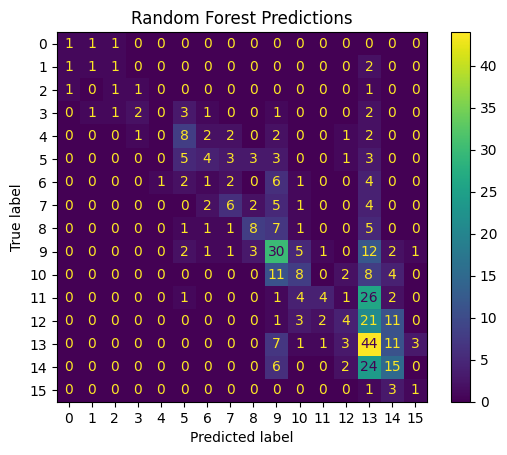

In [11]:
ConfusionMatrixDisplay(confusion_matrix(testy,forest_preds)).plot()
plt.title("Random Forest Predictions")
plt.savefig("RF.png")

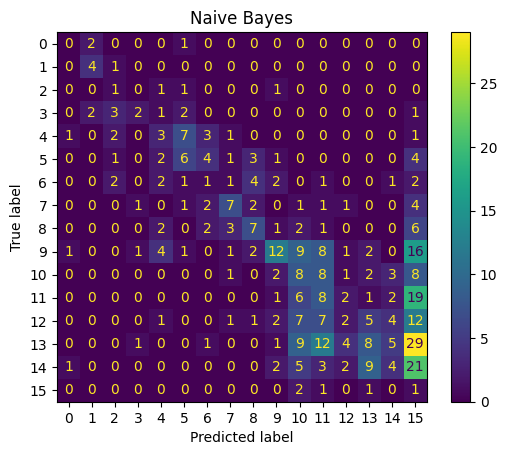

In [12]:
ConfusionMatrixDisplay(confusion_matrix(testy,gauss_preds)).plot()
plt.title("Naive Bayes")
plt.savefig("NB.png")

We see from these images that random forest is much better than naive bayes, though we can also see that label 13, or the 1680s, is predicted much more often than any other decade in random forest, which leads me to believe that most of the books came from the 1680s and that is skewing the model a bit.

In [13]:
print(np.mean([forest_preds==testy]))

0.3133971291866029


In [14]:
print(np.mean([gauss_preds==testy]))

0.17703349282296652


In [15]:
print(1/15)

0.06666666666666667


While both of these models are better than random guessing, they are a far cry from the accuracy that would be acceptable in order to replace other techniques of predicting when a document was written.  How does a basic neural net compare to these models, though?

In [16]:
from sklearn.neural_network import MLPClassifier

In [17]:
mlp = MLPClassifier(hidden_layer_sizes=[1000,500,100,50,25])

In [18]:
mlp.fit(trainx,trainy)

MLPClassifier(hidden_layer_sizes=[1000, 500, 100, 50, 25])

In [19]:
mlp_preds = mlp.predict(testx)

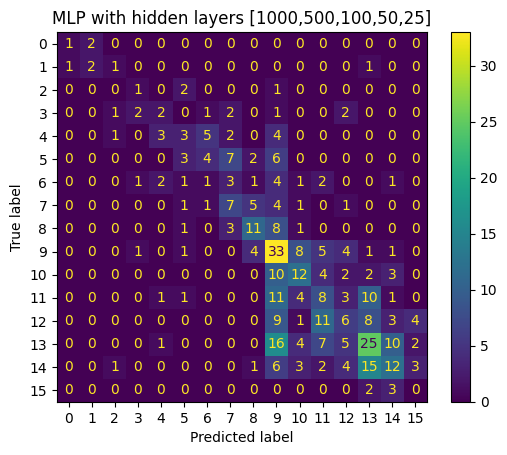

In [20]:
ConfusionMatrixDisplay(confusion_matrix(testy,mlp_preds)).plot()
plt.title("MLP with hidden layers [1000,500,100,50,25]")
plt.savefig("MLP.png")

In [21]:
print(np.mean([mlp_preds==testy]))

0.3014354066985646


As we can see, it did not perform as well as the random forest ensemble, despite being a far more complex model.  It also took far longer to fit itself to the data.

Then I wondered if there were hidden clusters in the data, and decided to use TSNE to see if we could reduce the dimensions to two, which hopefully the models would be able to use more effectively.

In [22]:
from sklearn.manifold import TSNE

In [23]:
transf = TSNE(n_components = 3)

In [24]:
newTrainX = transf.fit_transform(np.array(trainx))

In [25]:
tForest = RFC()
tGauss = GaussianNB()
tMLP = MLPClassifier(hidden_layer_sizes=[1000,500,100,50,25],max_iter=10000)

In [26]:
tForest.fit(newTrainX,trainy)

RandomForestClassifier()

In [27]:
tGauss.fit(newTrainX,trainy)

GaussianNB()

In [28]:
tMLP.fit(newTrainX,trainy)

MLPClassifier(hidden_layer_sizes=[1000, 500, 100, 50, 25], max_iter=10000)

In [29]:
newTestX = transf.fit_transform(np.array(testx))

In [30]:
newForestPreds = tForest.predict(newTestX)

In [31]:
newNBPreds = tGauss.predict(newTestX)

In [32]:
newMLPPreds = tMLP.predict(newTestX)

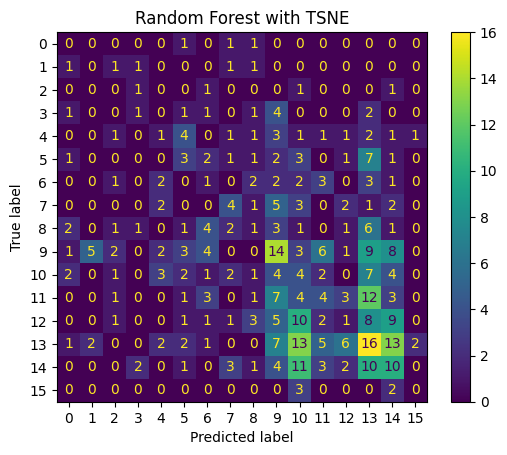

In [33]:
ConfusionMatrixDisplay(confusion_matrix(testy,newForestPreds)).plot()
plt.title("Random Forest with TSNE")
plt.savefig("ForestTSNE.png")

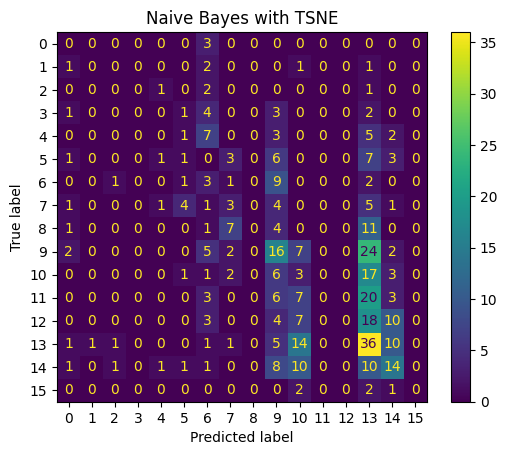

In [34]:
ConfusionMatrixDisplay(confusion_matrix(testy,newNBPreds)).plot()
plt.title("Naive Bayes with TSNE")
plt.savefig("NBTSNE.png")

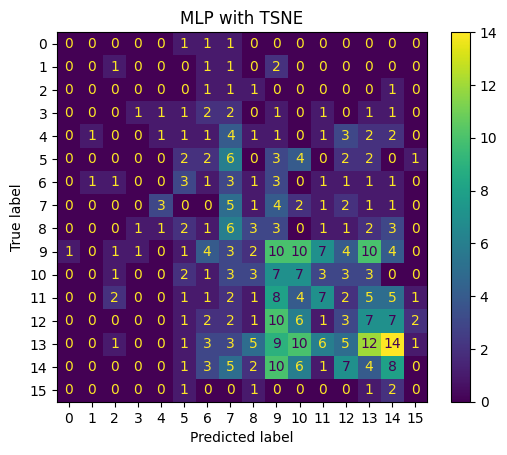

In [35]:
ConfusionMatrixDisplay(confusion_matrix(testy,newMLPPreds)).plot()
plt.title("MLP with TSNE")
plt.savefig("MLP with TSNE.png")

In [36]:
print(np.mean([newForestPreds==testy]))
print(np.mean([newNBPreds==testy]))
print(np.mean([newMLPPreds==testy]))

0.14354066985645933
0.18181818181818182
0.14354066985645933


Clearly, TSNE was not a step in the right direction. My next thought was to use SMOTE to try to overcome the underrepresentation inherent in some of the decades.

In [37]:
from imblearn.over_sampling import SMOTE

SMOTE is an algorithm to create fake datapoints for underrepresented classes, and I thought it would have a plave here, as some decades have very few books.

In [38]:
s = SMOTE(random_state=42)

In [39]:
strainx,strainy = s.fit_resample(trainx,trainy)

In [40]:
print(len(strainx)-len(trainx))

2218


In [41]:
sforest = RFC()

sMLP = MLPClassifier(hidden_layer_sizes=[1000,500,100,50,25],max_iter=10000)

In [42]:
sforest.fit(strainx,strainy)


RandomForestClassifier()

In [43]:
sMLP.fit(strainx,strainy)

MLPClassifier(hidden_layer_sizes=[1000, 500, 100, 50, 25], max_iter=10000)

In [44]:
sgauss = GaussianNB()
sgauss.fit(strainx,strainy)

GaussianNB()

In [45]:
sfpreds = sforest.predict(testx)
sgpreds = sgauss.predict(testx)
smpreds = sMLP.predict(testx)

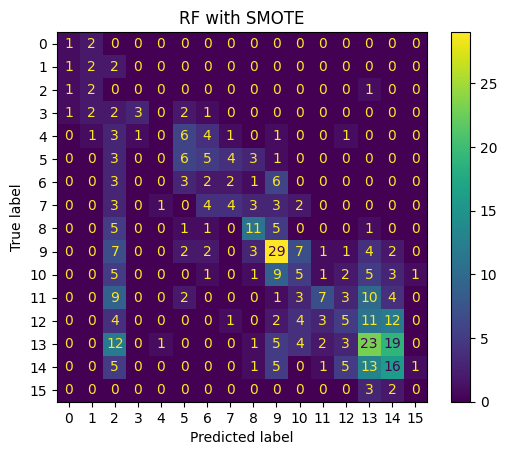

In [46]:
ConfusionMatrixDisplay(confusion_matrix(testy,sfpreds)).plot()
plt.title("RF with SMOTE")
plt.savefig("RF with SMOTE.png")

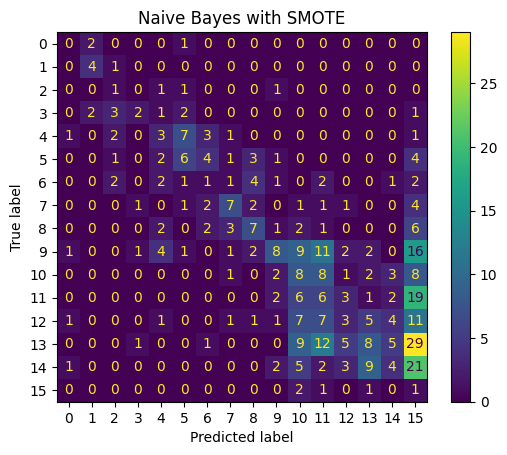

In [47]:
ConfusionMatrixDisplay(confusion_matrix(testy,sgpreds)).plot()
plt.title("Naive Bayes with SMOTE")
plt.savefig("Naive Bayes with SMOTE.png")

In [48]:
print(np.mean([sfpreds==testy]))
print(np.mean([sgpreds==testy]))
print(np.mean([smpreds==testy]))

0.2727272727272727
0.16507177033492823
0.24880382775119617


Sadly, even SMOTE wasn't a step in the right direction. So, I opted for hyperparameter optimization, to see if there was a simple way of boosting the accuracy of the model. Due to time constraints, I restricted the model type to only random forest models.  I did test hyperparameters on both the SMOTE data and the normal data, to see if there was a difference.

In [49]:
from sklearn.model_selection import GridSearchCV
params = {"n_estimators":[25,50,100,150,200,300],"max_depth":[None,10,20,30,40,50],"oob_score":[True,False]}
bestForest = GridSearchCV(RFC(),params).fit(trainx,trainy)

/home/blackthorn/Desktop/cs6470/env/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


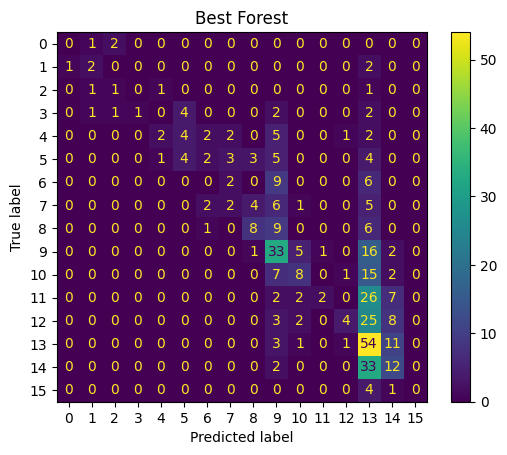

In [50]:
bpreds = bestForest.predict(testx)
ConfusionMatrixDisplay(confusion_matrix(testy,bpreds)).plot()
plt.title("Best Forest")
plt.savefig("Best Forest.png")

In [51]:
print(np.mean([bpreds==testy]))

0.3181818181818182


In [52]:
smoteForest = GridSearchCV(RFC(),params).fit(strainx,strainy)

/home/blackthorn/Desktop/cs6470/env/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [53]:
smotepreds = smoteForest.predict(testx)

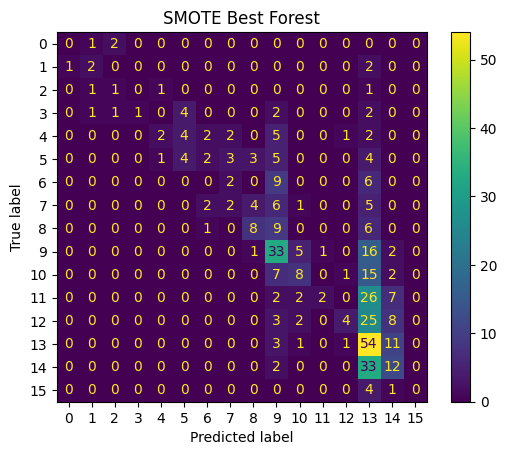

In [54]:
ConfusionMatrixDisplay(confusion_matrix(testy,bpreds)).plot()
plt.title("SMOTE Best Forest")
plt.savefig("SMOTE Best Forest.png")

In [55]:
print(np.mean([smotepreds==testy]))

0.2799043062200957


In [56]:
y = np.array(y)

In [57]:
print(bestForest.best_params_)

{'max_depth': 50, 'n_estimators': 200, 'oob_score': True}


In [58]:
print(smoteForest.best_params_)

{'max_depth': None, 'n_estimators': 300, 'oob_score': False}


Even the best model did not have the accuracy I was hoping for, though it was slightly better than the original accuracy.  In the future, I'll try to download the rest of the corpus, as well as test more models to see if we can eventually get closer to at least 90% accuracy. 